In [1]:
import baltic as bt
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon ## for polygons
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib.colors import LinearSegmentedColormap ## for colour maps
from matplotlib import gridspec ## for composite figures
import matplotlib.patheffects as path_effects ## for elegant text
from IPython.display import HTML
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from collections import Counter

def colourDict(data,cmap=mpl.cm.viridis):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name
    """
    cmap=cmap # default viridis
    data_unique=sorted(list(set(data))) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

def legend(dictionary,marker='o',markersize=15,labelspacing=1,fontsize=10,ax='',style='italic',loc='best',bbox_to_anchor=(0.5, 0.5),fontname='Arial'): # `'upper left', 'upper right', 'lower left', 'lower right'
    """ Returns a legend object from a dictionary"""
    legend_elements=[]
    for key,value in dictionary.items():
        legend_elements.append(Line2D([0],[0],marker=marker,color=value,label=key,markersize=markersize))
    leg=ax.legend(handles=legend_elements, loc=loc,labelspacing=labelspacing,prop={'size': fontsize,'style':style,'family':fontname},bbox_to_anchor=bbox_to_anchor)
    return leg

def tangled(tree,cladefix=0.001):
    """ takes a tree with or without collapsed clades and returns a dictionary of leafs and y coordinates"""
    cladefix=cladefix
    tip_ycoord_dict={}
    for k in tree.Objects:
        if isinstance(k,bt.leaf):
            tip_ycoord_dict[k.name]=k.y
        if isinstance(k,bt.clade):
            for n in k.subtree:  # iterates through the tips inside the collapsed clades
                if isinstance(n,bt.leaf):
                    tip_ycoord_dict[n.name]=k.y-cladefix*len(tree.Objects)
    return tip_ycoord_dict

# Loading the data

In [10]:
data=pd.read_csv('./coordinates_of_plants_and_ants.csv',sep=',')
# transform coordinates into column and row index of the raster

# the localities are near the political border and there are no biogeographical barriers between the two. 
data.replace('Boyaca','Casanare')
data
dataants=data[data['dataset']=='MFT']['Collection']
# filtering out collections of plants from other species that are not included in the analyses
datatococa=data[(data['Plant']=='Tococa guianensis') | (data['Plant']=='Tococa')]
datatococa

dataset              Plant        Ant Collection Department     Locality  \
6       MFT             Tococa  Allomerus     MFT145   Amazonas      Leticia   
8       MFT             Tococa     Azteca     MFT147   Amazonas      Leticia   
9       MFT             Tococa     Azteca     MFT148   Amazonas      Leticia   
10      MFT             Tococa     Azteca     MFT397  Antioquia   San Carlos   
11      MFT             Tococa     Azteca     MFT410   Putumayo  Villagarzon   
..      ...                ...        ...        ...        ...          ...   
516     MFT  Tococa guianensis   Tapinoma     MFT198      Choco        Arusi   
517     MFT  Tococa guianensis   Tapinoma     MFT218      Choco        Arusi   
518     MFT  Tococa guianensis   Tapinoma     MFT247      Choco        Arusi   
519     MFT  Tococa guianensis   Wasmania     MFT387  Antioquia     San Luis   
520     MFT  Tococa guianensis   Wasmania     MFT389  Antioquia     San Luis   

     Area (RASP)  Latitude  Longitude  Altitude (m)   
6            NaN -4.120267 -69.955150           94.0  
8            NaN -4.120033 -69.956267           92.0  
9            NaN -4.120033 -69.956267           92.0  
10           NaN  6.194390 -75.005780         1111.0  
11           NaN  1.060820 -76.622430          515.0  
..           ...       ...        ...            ...  
516          NaN  5.571430 -77.500740           99.0  
517          NaN  5.571650 -77.502010           60.0  
518          NaN  5.575040 -77.497330           89.0  
519          NaN  6.048130 -74.990980          988.0  
520          NaN  6.194370 -75.005480         1084.0  

[338 rows x 10 columns]

# Loading the trees

In [276]:
antmcct_path='Azteca_NCBI_MFT_OUT_ITS_30-01-18_mcct.tree'#'./Azteca_exp_strict_ITS2_yule_min_mcct.tre'
plantmcct_path='Melastomataceae_aln_short_23-03-18_mcct.tree'#'./Tococa_ITS_calibration_2017_mcct.tre'

anttree=bt.loadNexus(antmcct_path,absoluteTime=False)
anttree.traverse_tree()
anttree.treeStats()
anttree.drawTree()
anttree.setAbsoluteTime(0)

planttree=bt.loadNexus(plantmcct_path,absoluteTime=False)
planttree.traverse_tree()
planttree.treeStats()
planttree.drawTree()
planttree.setAbsoluteTime(0)


Tree height: 64.152808
Tree length: 1246.039982
strictly bifurcating tree
annotations present

Numbers of objects in tree: 811 (405 nodes and 406 leaves)


Tree height: 69.787938
Tree length: 6940.531988
strictly bifurcating tree
annotations present

Numbers of objects in tree: 1627 (813 nodes and 814 leaves)



In [277]:
# setting lists and dictionaries:
# all locations
locations=list(data['Locality'].unique())
# dictionary of areas:colour for the ancestral area reconstructions
area_dict_col={'Santander':'#deebf7','Choco':'#08519c','Valle del Cauca':'#4292c6','Antioquia':'#9ecae1', # west
               'Casanare':'#fed976','Meta':'#fd8d3c','Putumayo':'#e31a1c','Amazonas':'#800026', # east
               'Cundinamarca':'#f1b6da', # East Magdalena river but west to Eastern Cordillera
               'Magdalena valley':'#b8e186', # West Magdalena river and west to Eastern Cordillera
#                'Quindio':'#4d9221',
                'none':'#a3a3a3',np.nan:'#a3a3a3'} # west
area_dict_RASP={'Santander':'G','Choco':'C','Valle del Cauca':'A','Antioquia':'E', # west
               'Casanare':'H','Meta':'D','Putumayo':'F','Amazonas':'B', # east
               'Cundinamarca':'K', # East Magdalena river but west to Eastern Cordillera
               'Magdalena valley':'I', # West Magdalena river and west to Eastern Cordillera
#                'Quindio':'J', 
                'none':'N',np.nan:'N'} # west
                
area_dict={'Barrancabermeja':'Santander','Cimitarra':'Santander',
           'Anolaima':'Cundinamarca',
           'Payande':'Magdalena valley','Cocora':'Magdalena valley','Padua':'Magdalena valley','Mariquita':'Magdalena valley','Espinal':'Magdalena valley','Guayabal':'Magdalena valley',
           'Calarca':'Magdalena valley','Quimbaya':'Magdalena valley','Manizales':'Magdalena valley',
           'Arusi':'Choco','Solano':'Choco',
           'Buenaventura':'Valle del Cauca','Calima':'Valle del Cauca','Cali':'Valle del Cauca','El Cerrito':'Valle del Cauca','Jamundi':'Valle del Cauca',
           'San Carlos':'Antioquia','San Luis':'Antioquia','Amalfi':'Antioquia','Yolombo':'Antioquia','Valdivia':'Antioquia','Barbosa':'Antioquia',
          'Tauramena':'Casanare','Villanueva':'Casanare','San Luis de Gaceno':'Casanare',
           'Villavicencio':'Meta','Acacías':'Meta','S.J. de Arama':'Meta','Barranca de Upia':'Meta','Puerto Gaitan':'Meta',
           'Villagarzon':'Putumayo',
           'Leticia':'Amazonas','Puerto Nariño':'Amazonas',
            'none':'none',np.nan:'none'}

geol_time_dict={'Hol':(0,0.011700),
               'Ple':(0.011700,2.58),
               'Pli':(2.58,5.333),
               'Mio':(5.333,23.03),
               'Oli':(23.0,33.9),
               'Eoc':(33.9,56.0),
               'Pal':(56.0,66.0),
               'LCre':(66.0,90)} # ends in 100.5 but 70 for convenience


# adding numbers
loc_tuples=[(index+1,loc) for index,loc in enumerate(locations)]

# dictionary location:location number
loc_num_dict=dict(zip([x[1] for x in loc_tuples],[x[0] for x in loc_tuples]))

# dictionary of tree_tip:locality
# make sure k.name corresponds to the info in data['Collection']
tiplocal_dict=dict(zip(data['Collection'],data['Locality']))
tiplocal_dict['none']='#a3a3a3'

# display name dictionary
anttipdisplay_dict=dict(zip(data['Collection'],['%s %s'%(row.Ant,row.Collection) if row.dataset == 'MFT' else '%s'%(row.Ant) for row in data.itertuples()]))
planttipdisplay_dict=dict(zip(data['Collection'],['%s %s'%(row.Plant,row.Collection) if row.dataset == 'MFT' else '%s'%(row.Plant) for row in data.itertuples()]))

# dictionary ant:plant
antplant_dict=dict(zip(data['Collection'],data['Plant']))

# tip dataset dict
dataset_dict=dict(zip(data['Collection'],data['dataset']))
# annotate the Azteca tree nodes with the region
for tree in [anttree,planttree]:
    for k in tree.Objects:
        if isinstance(k,bt.leaf): # iterates through the tip
            cur_node=k
            while cur_node:
                cur_node.traits['locality']=tiplocal_dict[k.name] if k.name in tiplocal_dict.keys() else 'none' # annotates the parental nodes with the genus name. Done for colouring the branches based on genera
                cur_node=cur_node.parent
                
data['Area (RASP)']=''
for row in data.itertuples():
    data.loc[row.Index,'Area (RASP)']=area_dict_RASP[area_dict[row.Locality]]
data[['Collection','Area (RASP)']].to_csv('./rasp_regions.csv',sep=',')
data

dataset              Plant                        Ant  \
0        MFT   Tococa bullifera                  Allomerus   
1        MFT   Tococa bullifera                  Allomerus   
2        MFT   Tococa bullifera                  Allomerus   
3        MFT  Maieta guianensis                  Allomerus   
4        MFT  Maieta guianensis                  Allomerus   
...      ...                ...                        ...   
1353    NCBI                NaN     Azteca beltii JQ867866   
1354    NCBI                NaN   Azteca pittieri JQ867867   
1355    NCBI                NaN  Azteca nigricans JQ867868   
1356    NCBI                NaN  Azteca nigricans JQ867869   
1357    NCBI                NaN     Azteca beltii JQ867870   

                 Collection Department     Locality Area (RASP)  Latitude  \
0                    MFT411   Putumayo  Villagarzon           F  1.060820   
1                    MFT412   Putumayo  Villagarzon           F  1.059340   
2                    MFT441   Putumayo  Villagarzon           F  1.059420   
3                    MFT142   Amazonas      Leticia           B -4.120267   
4                    MFT143   Amazonas      Leticia           B -4.120267   
...                     ...        ...          ...         ...       ...   
1353  JQ867866_Az_belt_Z178        NaN          NaN           N       NaN   
1354  JQ867867_Az_pitt_Z180        NaN          NaN           N       NaN   
1355  JQ867868_Az_nigr_Z253        NaN          NaN           N       NaN   
1356  JQ867869_Az_nigr_Z255        NaN          NaN           N       NaN   
1357  JQ867870_Az_belt_Z256        NaN          NaN           N       NaN   

      Longitude  Altitude (m)   
0     -76.62243          515.0  
1     -76.62243          479.0  
2     -76.62523          550.0  
3     -69.95515           94.0  
4     -69.95515           94.0  
...         ...            ...  
1353        NaN            NaN  
1354        NaN            NaN  
1355        NaN            NaN  
1356        NaN            NaN  
1357        NaN            NaN  

[1358 rows x 10 columns]

# Plot the uncollapsed Ant phylogeny

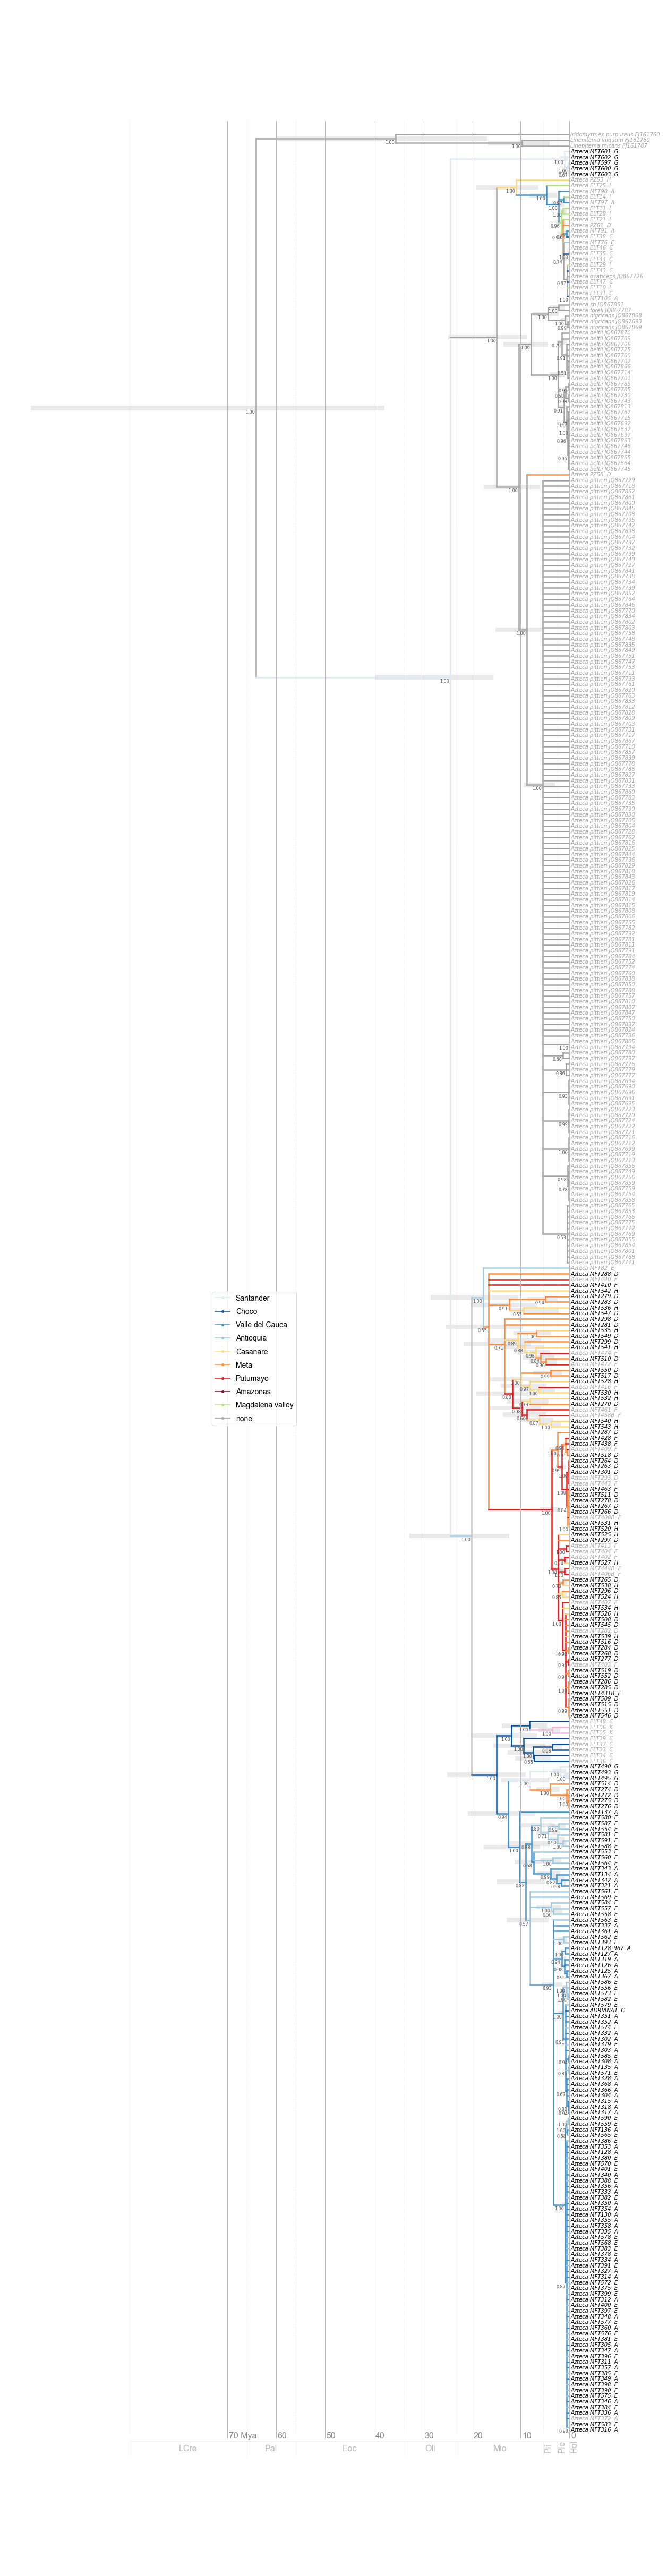

In [280]:
fig,ax = plt.subplots(figsize=(20,89),facecolor='none')

atree=anttree.collapseBranches(lambda k: 'posterior' not in k.traits or k.traits['posterior'] <= 0.5)
x_attr=lambda k: k.x-atree.treeHeight if k.x else -atree.treeHeight
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
b_func=lambda k: 2.5 ## branch width function
s_func=lambda k: 600-30*k.height/anttree.treeHeight ## size of tips
z_func=lambda k: 100

atree.plotTree(ax,x_attr=x_attr,colour=bc_func,width=b_func) ## plot branches

for k in atree.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        ax.text(k.x-atree.treeHeight+0.2,k.y,'%s  %s'%(anttipdisplay_dict[k.name] if k.name in anttipdisplay_dict.keys() else k.name,area_dict_RASP[area_dict[k.traits['locality']]] if dataset_dict[k.name] == 'MFT' else ''),
                va='center', ha='left',size=10,
                color='k' if k.name in anttipdisplay_dict.keys() and antplant_dict[k.name] in ['Tococa','Tococa guianensis'] and k.name in antplant_dict.keys() else '#a3a3a3', style='italic')
    else:
        if 'posterior' in k.traits and k.traits['posterior'] > 0.50:
            ax.text(k.height-atree.treeHeight-0.2,k.y-0.25,'%1.2f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),
                    va='top',ha='right',size=8,color='#545454',zorder=100)
        if  'height_95%_HPD' in k.traits:
            height=0.8
            left=-k.traits['height_95%_HPD'][1]  # past to present
            bottom=k.y-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.3)
            ax.add_patch(box)
ymax=408
for x in range(0,80,10):
    ax.vlines(x=-x,ymin=-1,ymax=ymax,ls='-',lw=1,color='#bababa',alpha=1)
    ax.text(x=-x+0.3,y=-1,s='%s'%(x) if x != 70 else '%s Mya'%(x),fontname='Arial',fontsize=16,color='#878787')
plt.xticks([])
plt.yticks([])

but=['Hol','Ple','Pli']
ax.hlines(y=-1.5,xmin=0,xmax=-geol_time_dict['LCre'][1],ls='-',lw=1,color='#bababa',alpha=0.2)
for epoc,value in geol_time_dict.items():
    ax.vlines(x=-value[1],ymin=-4,ymax=-1.5,ls='-',lw=1,color='#bababa',alpha=0.2)
    ax.vlines(x=-value[1],ymin=0,ymax=ymax,ls='--',lw=1,color='#bababa',alpha=0.2)
    xbut,rotbut=(value[1]-1,90) if epoc in but else ((value[1]+value[0])/2,0)
    ax.text(x=-xbut,y=-3.2,s='%s'%(epoc),fontname='Arial',fontsize=16,color='#bababa',ha='center',rotation=rotbut)
[ax.spines[loc].set_visible(False) for loc in ax.spines]

legend({key:value for key,value in area_dict_col.items() if key not in ['Cundinamarca','Quindio','Tolima',np.nan]},marker='.',markersize=8,labelspacing=0.8,fontsize=14,ax=ax,style='normal',loc='best',fontname='Arial') #,bbox_to_anchor=(0.5, 0.5)
plt.savefig('./SFig_1_Azteca_mcct_20210106.pdf',pdi=300)
plt.show()

# Plot the uncollapsed plant phylogeny

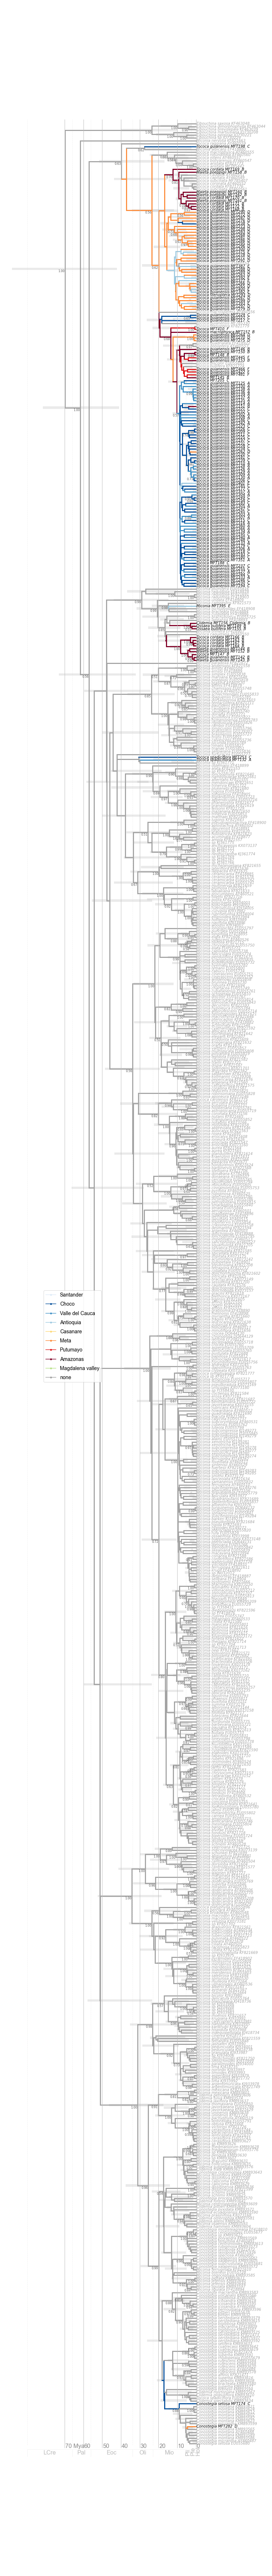

In [281]:
fig,ax = plt.subplots(figsize=(10,130),facecolor='none')

atree=planttree#.collapseBranches(lambda k: 'posterior' not in k.traits or k.traits['posterior'] <= 0.5)
x_attr=lambda k: k.x-atree.treeHeight if k.x else -atree.treeHeight
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
b_func=lambda k: 3 ## branch width function
s_func=lambda k: 600-30*k.height/anttree.treeHeight ## size of tips
z_func=lambda k: 100

atree.plotTree(ax,x_attr=x_attr,colour=bc_func,width=b_func) ## plot branches

for k in atree.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        ax.text(k.x-atree.treeHeight+0.2,k.y,'%s  %s'%(planttipdisplay_dict[k.name] if k.name in planttipdisplay_dict.keys() else k.name,area_dict_RASP[area_dict[k.traits['locality']]] if dataset_dict[k.name] == 'MFT' else ''),
                va='center', ha='left',size=10,
                color='k' if dataset_dict[k.name] == 'MFT' and k.name in planttipdisplay_dict.keys() else '#a3a3a3', style='italic')
    else:
        if 'posterior' in k.traits and k.traits['posterior'] > 0.50:
            ax.text(k.height-atree.treeHeight-0.2,k.y-0.25,'%1.2f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),
                    va='top',ha='right',size=8,color='#545454',zorder=100)
        if  'height_95%_HPD' in k.traits:
            height=0.8
            left=-k.traits['height_95%_HPD'][1]  # past to present
            bottom=k.y-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.3)
            ax.add_patch(box)
ymax=815
for x in range(0,80,10):
    ax.vlines(x=-x,ymin=-1,ymax=ymax,ls='-',lw=1,color='#bababa',alpha=1)
    ax.text(x=-x+0.3,y=-1,s='%s'%(x) if x != 70 else '%s Mya'%(x),fontname='Arial',fontsize=16,color='#878787')
plt.xticks([])
plt.yticks([])

but=['Hol','Ple','Pli']
ax.hlines(y=-1.5,xmin=0,xmax=-geol_time_dict['LCre'][1],ls='-',lw=1,color='#bababa',alpha=0.2)
for epoc,value in geol_time_dict.items():
    ax.vlines(x=-value[1],ymin=-4,ymax=-1.5,ls='-',lw=1,color='#bababa',alpha=0.2)
    ax.vlines(x=-value[1],ymin=0,ymax=ymax,ls='--',lw=1,color='#bababa',alpha=0.2)
    xbut,rotbut=(value[1]-1,90) if epoc in but else ((value[1]+value[0])/2,0)
    ax.text(x=-xbut,y=-3.2,s='%s'%(epoc),fontname='Arial',fontsize=16,color='#bababa',ha='center',rotation=rotbut)
[ax.spines[loc].set_visible(False) for loc in ax.spines]

legend({key:value for key,value in area_dict_col.items() if key not in ['Cundinamarca','Quindio','Tolima',np.nan]},
       marker='.',markersize=8,labelspacing=0.8,fontsize=14,ax=ax,style='normal',loc='best',fontname='Arial') #,bbox_to_anchor=(0.5, 0.5)
plt.savefig('./SFig_1_Tococa_mcct_20210106.pdf',pdi=300)
plt.show()

# Subsampling Melastomataceae and Azteca trees

to leave only *T. guianensis*, samples collected during this study, and some members of their clades for phylogenetic reference.

In [247]:
others=['JQ730208_Tibouchina_martiusiana','KF821663_Mic_nervosa_Nee_55264','EF418880_Mic_albicans_Martin_403','EF418907_Mic_trimera_Martin_469','KF821635_Mic_lappacea_Irwin_48319','EF418886_Mic_cuspidata_Renner_2160b','KF821573_Mic_campestris_Redden_1281','EF418903_Mic_radulifolia_Clark_6732','KJ361771_Mic_sp_Almeda_10470','KM893565_Con_montana_T2093','EF418884_Mic_bracteata_Martin_443','KM893599_Con_micrantha_T1590','KM893616_Con_superba_T500']
keep_plants=[k for k in planttree.Objects if k.branchType=='leaf' and dataset_dict[k.name] == 'MFT']+[k for k in planttree.Objects if k.branchType=='leaf' and k.name in others] ## list of leaf objects that will remain in the tree
# keep_plants.append([k for k in planttree.Objects if k.branchType=='leaf' and k.name in others])
plantreduced=planttree.reduceTree(keep_plants) ## retrieve a reduced tree (multitype by default)
# print(keep_plants)

In [248]:
others=['FJ161760_Irid_purpureus_AW28','FJ161780_Lin_iniquum_AW23','FJ161787_Lin_micans_AT','JQ867690_Az_pitt_B048','JQ867714_Az_belt_B159','JQ867868_Az_nigr_Z253','JQ867726_Az_ovat_B224']
keep_ants=[k for k in anttree.Objects if k.branchType=='leaf' and dataset_dict[k.name] =='MFT']+[k for k in anttree.Objects if k.branchType=='leaf' and k.name in others] ## list of leaf objects that will remain in the tree
antreduced=anttree.reduceTree(keep_ants) ## retrieve a reduced tree (multitype by default)

In [249]:
for i,tree in enumerate([antreduced,plantreduced]):
    for k in tree.Objects:
        if isinstance(k,bt.leaf): # iterates through the tip
            cur_node=k
            while cur_node:
                cur_node.traits['locality']=tiplocal_dict[k.name] if k.name in tiplocal_dict.keys() else 'none' # annotates the parental nodes with the genus name. Done for colouring the branches based on genera
                cur_node=cur_node.parent

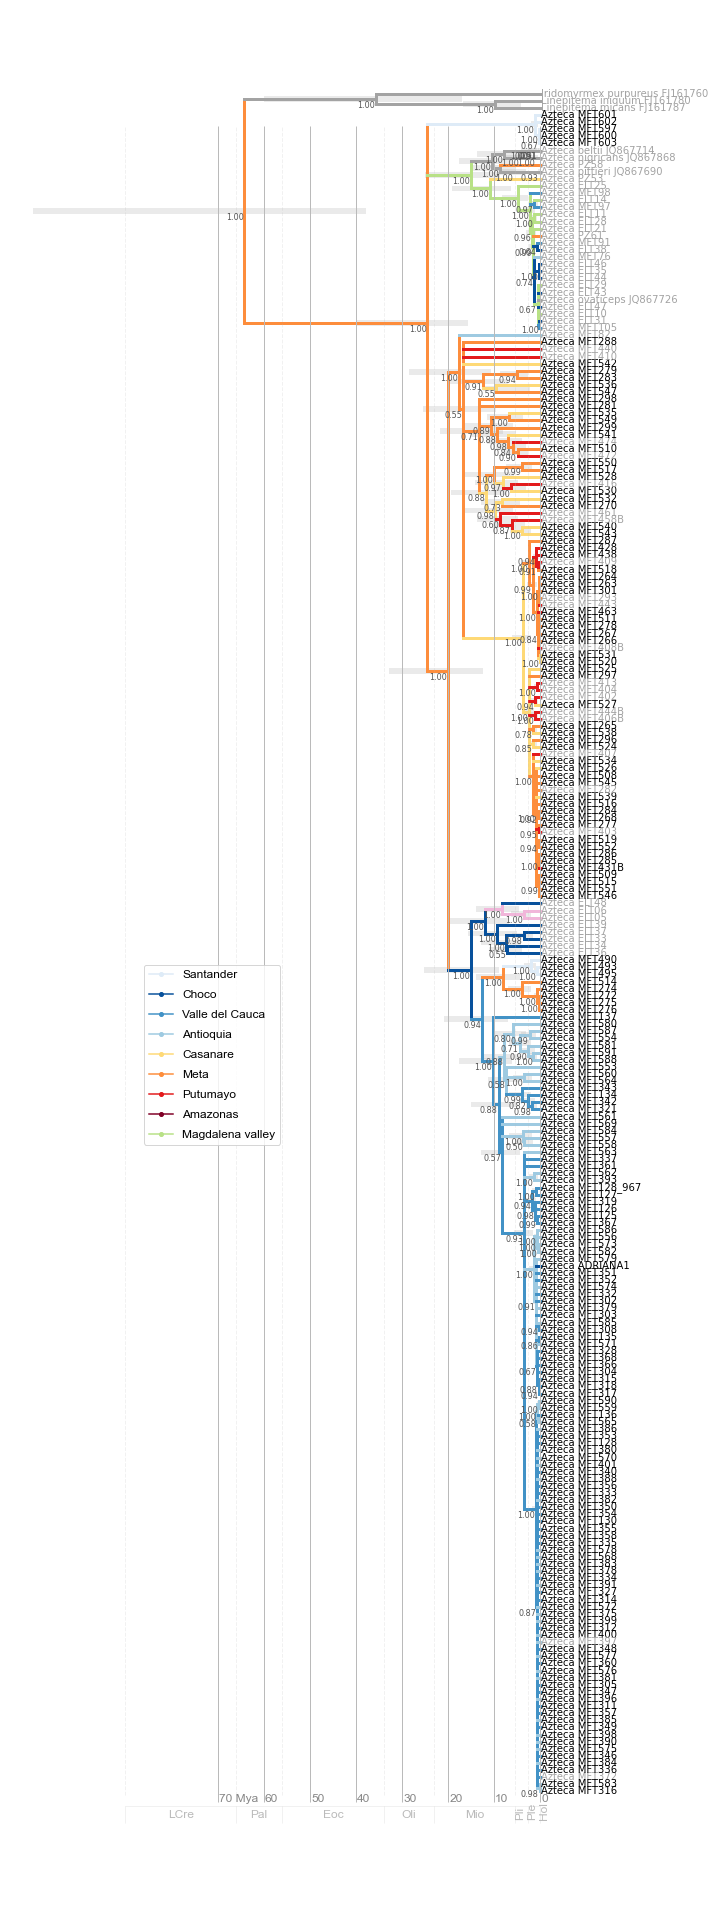

In [262]:
fig,ax = plt.subplots(figsize=(10,35),facecolor='none')

atree=antreduced.collapseBranches(lambda k: 'posterior' not in k.traits or k.traits['posterior'] <= 0.5)
x_attr=lambda k: k.x-atree.treeHeight if k.x else -atree.treeHeight
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
b_func=lambda k: 3 ## branch width function
s_func=lambda k: 600-30*k.height/anttree.treeHeight ## size of tips
z_func=lambda k: 100

atree.plotTree(ax,x_attr=x_attr,colour=bc_func,width=b_func) ## plot branches

for k in atree.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        ax.text(k.x-atree.treeHeight+0.2,k.y,'%s'%(anttipdisplay_dict[k.name] if k.name in anttipdisplay_dict.keys() else k.name), #area_dict_RASP[area_dict[k.traits['locality']]] if dataset_dict[k.name] == 'MFT' else ''),
                va='center', ha='left',size=10,
                color='k' if antplant_dict[k.name] == 'Tococa guianensis' else '#a3a3a3')
#                 color='k' if k.name in anttipdisplay_dict.keys() and 'Tococa' in antplant_dict[k.name] and k.name in antplant_dict.keys() else '#a3a3a3', style='italic')

    else:
        if 'posterior' in k.traits and k.traits['posterior'] > 0.50:
            ax.text(k.height-atree.treeHeight-0.2,k.y-0.25,'%1.2f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),
                    va='top',ha='right',size=8,color='#545454',zorder=100)
        if  'height_95%_HPD' in k.traits:
            height=0.8
            left=-k.traits['height_95%_HPD'][1]  # past to present
            bottom=k.y-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.3)
            ax.add_patch(box)
ymax=235
for x in range(0,80,10):
    ax.vlines(x=-x,ymin=-1,ymax=ymax,ls='-',lw=1,color='#bababa',alpha=1)
    ax.text(x=-x+0.3,y=-1,s='%s'%(x) if x != 70 else '%s Mya'%(x),fontname='Arial',fontsize=12,color='#878787')
plt.xticks([])
plt.yticks([])

but=['Hol','Ple','Pli']
ax.hlines(y=-1.5,xmin=0,xmax=-geol_time_dict['LCre'][1],ls='-',lw=1,color='#bababa',alpha=0.2)
for epoc,value in geol_time_dict.items():
    ax.vlines(x=-value[1],ymin=-4,ymax=-1.5,ls='-',lw=1,color='#bababa',alpha=0.2)
    ax.vlines(x=-value[1],ymin=0,ymax=ymax,ls='--',lw=1,color='#bababa',alpha=0.2)
    xbut,rotbut=(value[1]-1,90) if epoc in but else ((value[1]+value[0])/2,0)
    ax.text(x=-xbut,y=-3.2,s='%s'%(epoc),fontname='Arial',fontsize=12,color='#bababa',ha='center',rotation=rotbut)
[ax.spines[loc].set_visible(False) for loc in ax.spines]

legend({key:value for key,value in area_dict_col.items() if key not in ['Cundinamarca','Quindio','Tolima','none',np.nan]},
       marker='.',markersize=8,labelspacing=0.8,fontsize=12,ax=ax,style='normal',loc='best',fontname='Arial') #,bbox_to_anchor=(0.5, 0.5)
# plt.savefig('./SFig_1_Tococa_shortened_mcct_20210106.pdf',pdi=300)
plt.show()

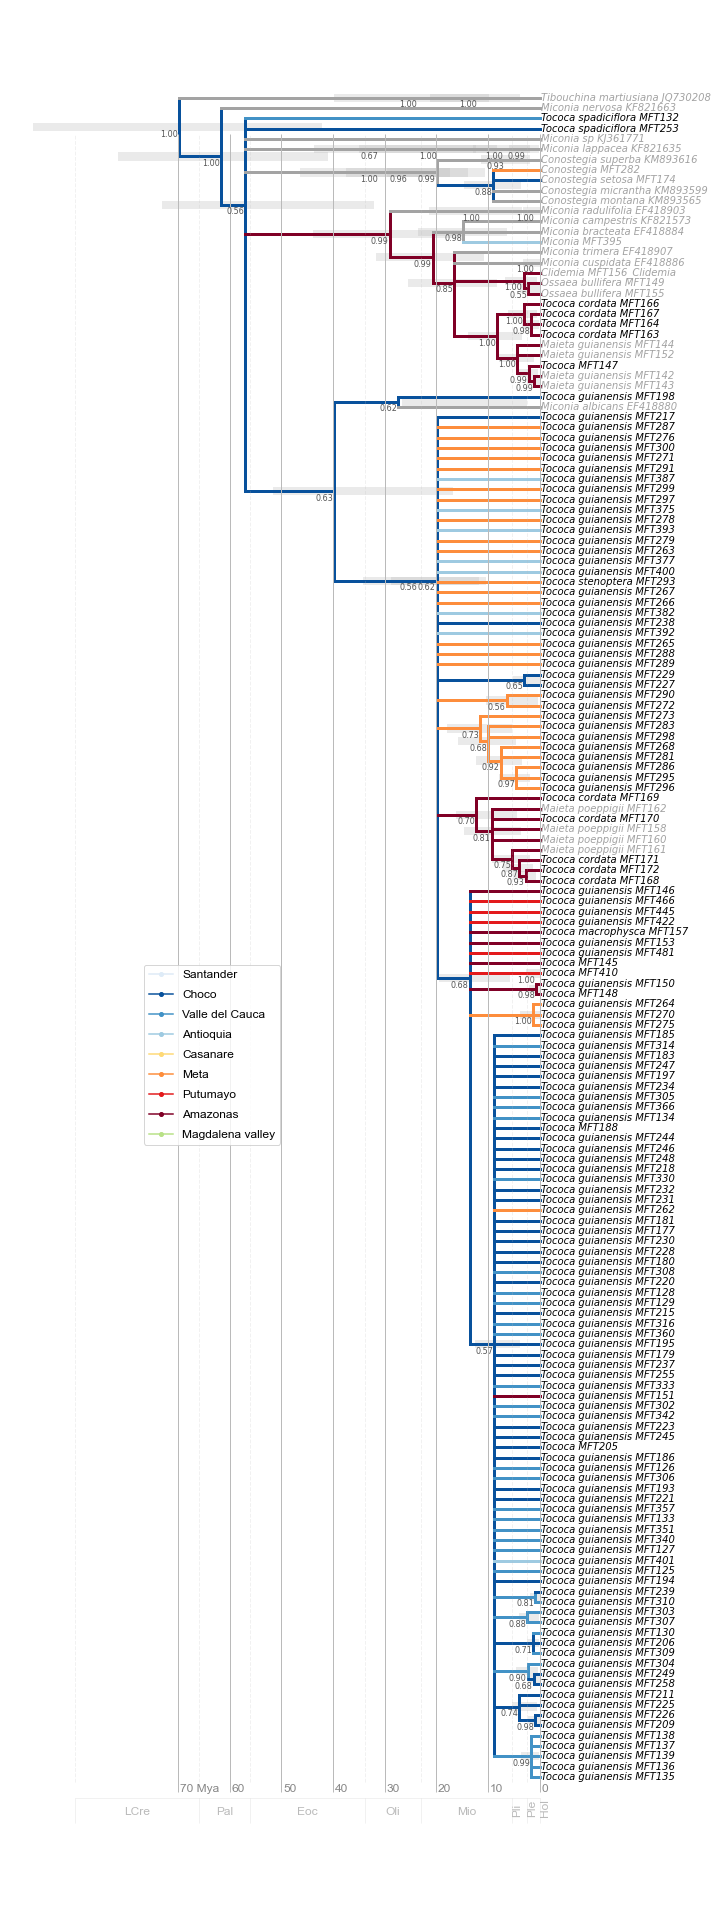

In [263]:
fig,ax = plt.subplots(figsize=(10,35),facecolor='none')

atree=plantreduced.collapseBranches(lambda k: 'posterior' not in k.traits or k.traits['posterior'] <= 0.5)
x_attr=lambda k: k.x-atree.treeHeight if k.x else -atree.treeHeight
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
b_func=lambda k: 3 ## branch width function
s_func=lambda k: 600-30*k.height/anttree.treeHeight ## size of tips
z_func=lambda k: 100

atree.plotTree(ax,x_attr=x_attr,colour=bc_func,width=b_func) ## plot branches

for k in atree.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        ax.text(k.x-atree.treeHeight+0.2,k.y,'%s'%(planttipdisplay_dict[k.name] if k.name in planttipdisplay_dict.keys() else k.name),#area_dict_RASP[area_dict[k.traits['locality']]] if dataset_dict[k.name] == 'MFT' else ''),
                va='center', ha='left',size=10,
                color='k' if k.name in planttipdisplay_dict.keys() and 'Tococa' in antplant_dict[k.name] and k.name in antplant_dict.keys() else '#a3a3a3', style='italic')
    else:
        if 'posterior' in k.traits and k.traits['posterior'] > 0.50:
            ax.text(k.height-atree.treeHeight-0.2,k.y-0.25,'%1.2f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),
                    va='top',ha='right',size=8,color='#545454',zorder=100)
        if  'height_95%_HPD' in k.traits:
            height=0.8
            left=-k.traits['height_95%_HPD'][1]  # past to present
            bottom=k.y-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.3)
            ax.add_patch(box)
ymax=160
for x in range(0,80,10):
    ax.vlines(x=-x,ymin=-1,ymax=ymax,ls='-',lw=1,color='#bababa',alpha=1)
    ax.text(x=-x+0.3,y=-1,s='%s'%(x) if x != 70 else '%s Mya'%(x),fontname='Arial',fontsize=12,color='#878787')
plt.xticks([])
plt.yticks([])

but=['Hol','Ple','Pli']
ax.hlines(y=-1.5,xmin=0,xmax=-geol_time_dict['LCre'][1],ls='-',lw=1,color='#bababa',alpha=0.2)
for epoc,value in geol_time_dict.items():
    ax.vlines(x=-value[1],ymin=-4,ymax=-1.5,ls='-',lw=1,color='#bababa',alpha=0.2)
    ax.vlines(x=-value[1],ymin=0,ymax=ymax,ls='--',lw=1,color='#bababa',alpha=0.2)
    xbut,rotbut=(value[1]-1,90) if epoc in but else ((value[1]+value[0])/2,0)
    ax.text(x=-xbut,y=-3.2,s='%s'%(epoc),fontname='Arial',fontsize=12,color='#bababa',ha='center',rotation=rotbut)
[ax.spines[loc].set_visible(False) for loc in ax.spines]

legend({key:value for key,value in area_dict_col.items() if key not in ['Cundinamarca','Quindio','Tolima','none',np.nan]},
       marker='.',markersize=8,labelspacing=0.8,fontsize=12,ax=ax,style='normal',loc='best',fontname='Arial') #,bbox_to_anchor=(0.5, 0.5)
# plt.savefig('./SFig_1_Tococa_shortened_mcct_20210106.pdf',pdi=300)
plt.show()

# Full tanglegram

In [266]:
antreducedcoll=antreduced.collapseBranches(lambda k: 'posterior' not in k.traits or k.traits['posterior'] <= 0.5)
plantreducedcoll=plantreduced.collapseBranches(lambda k: 'posterior' not in k.traits or k.traits['posterior'] <= 0.5)

tip_positions={x:{} for x in [antreducedcoll,plantreducedcoll]} ## remember the position of each tip in each tree
for t,tr in enumerate([antreducedcoll,plantreducedcoll]): ## iterate over trees
    cur_tree=tr ## fetch tree object
    for k in cur_tree.Objects:
        if k.branchType=='leaf':
            tip_positions[tr][k.name]=(k.height,k.y) ## remember (X, Y) position of tip

64.15280846410059 102.64449354256098


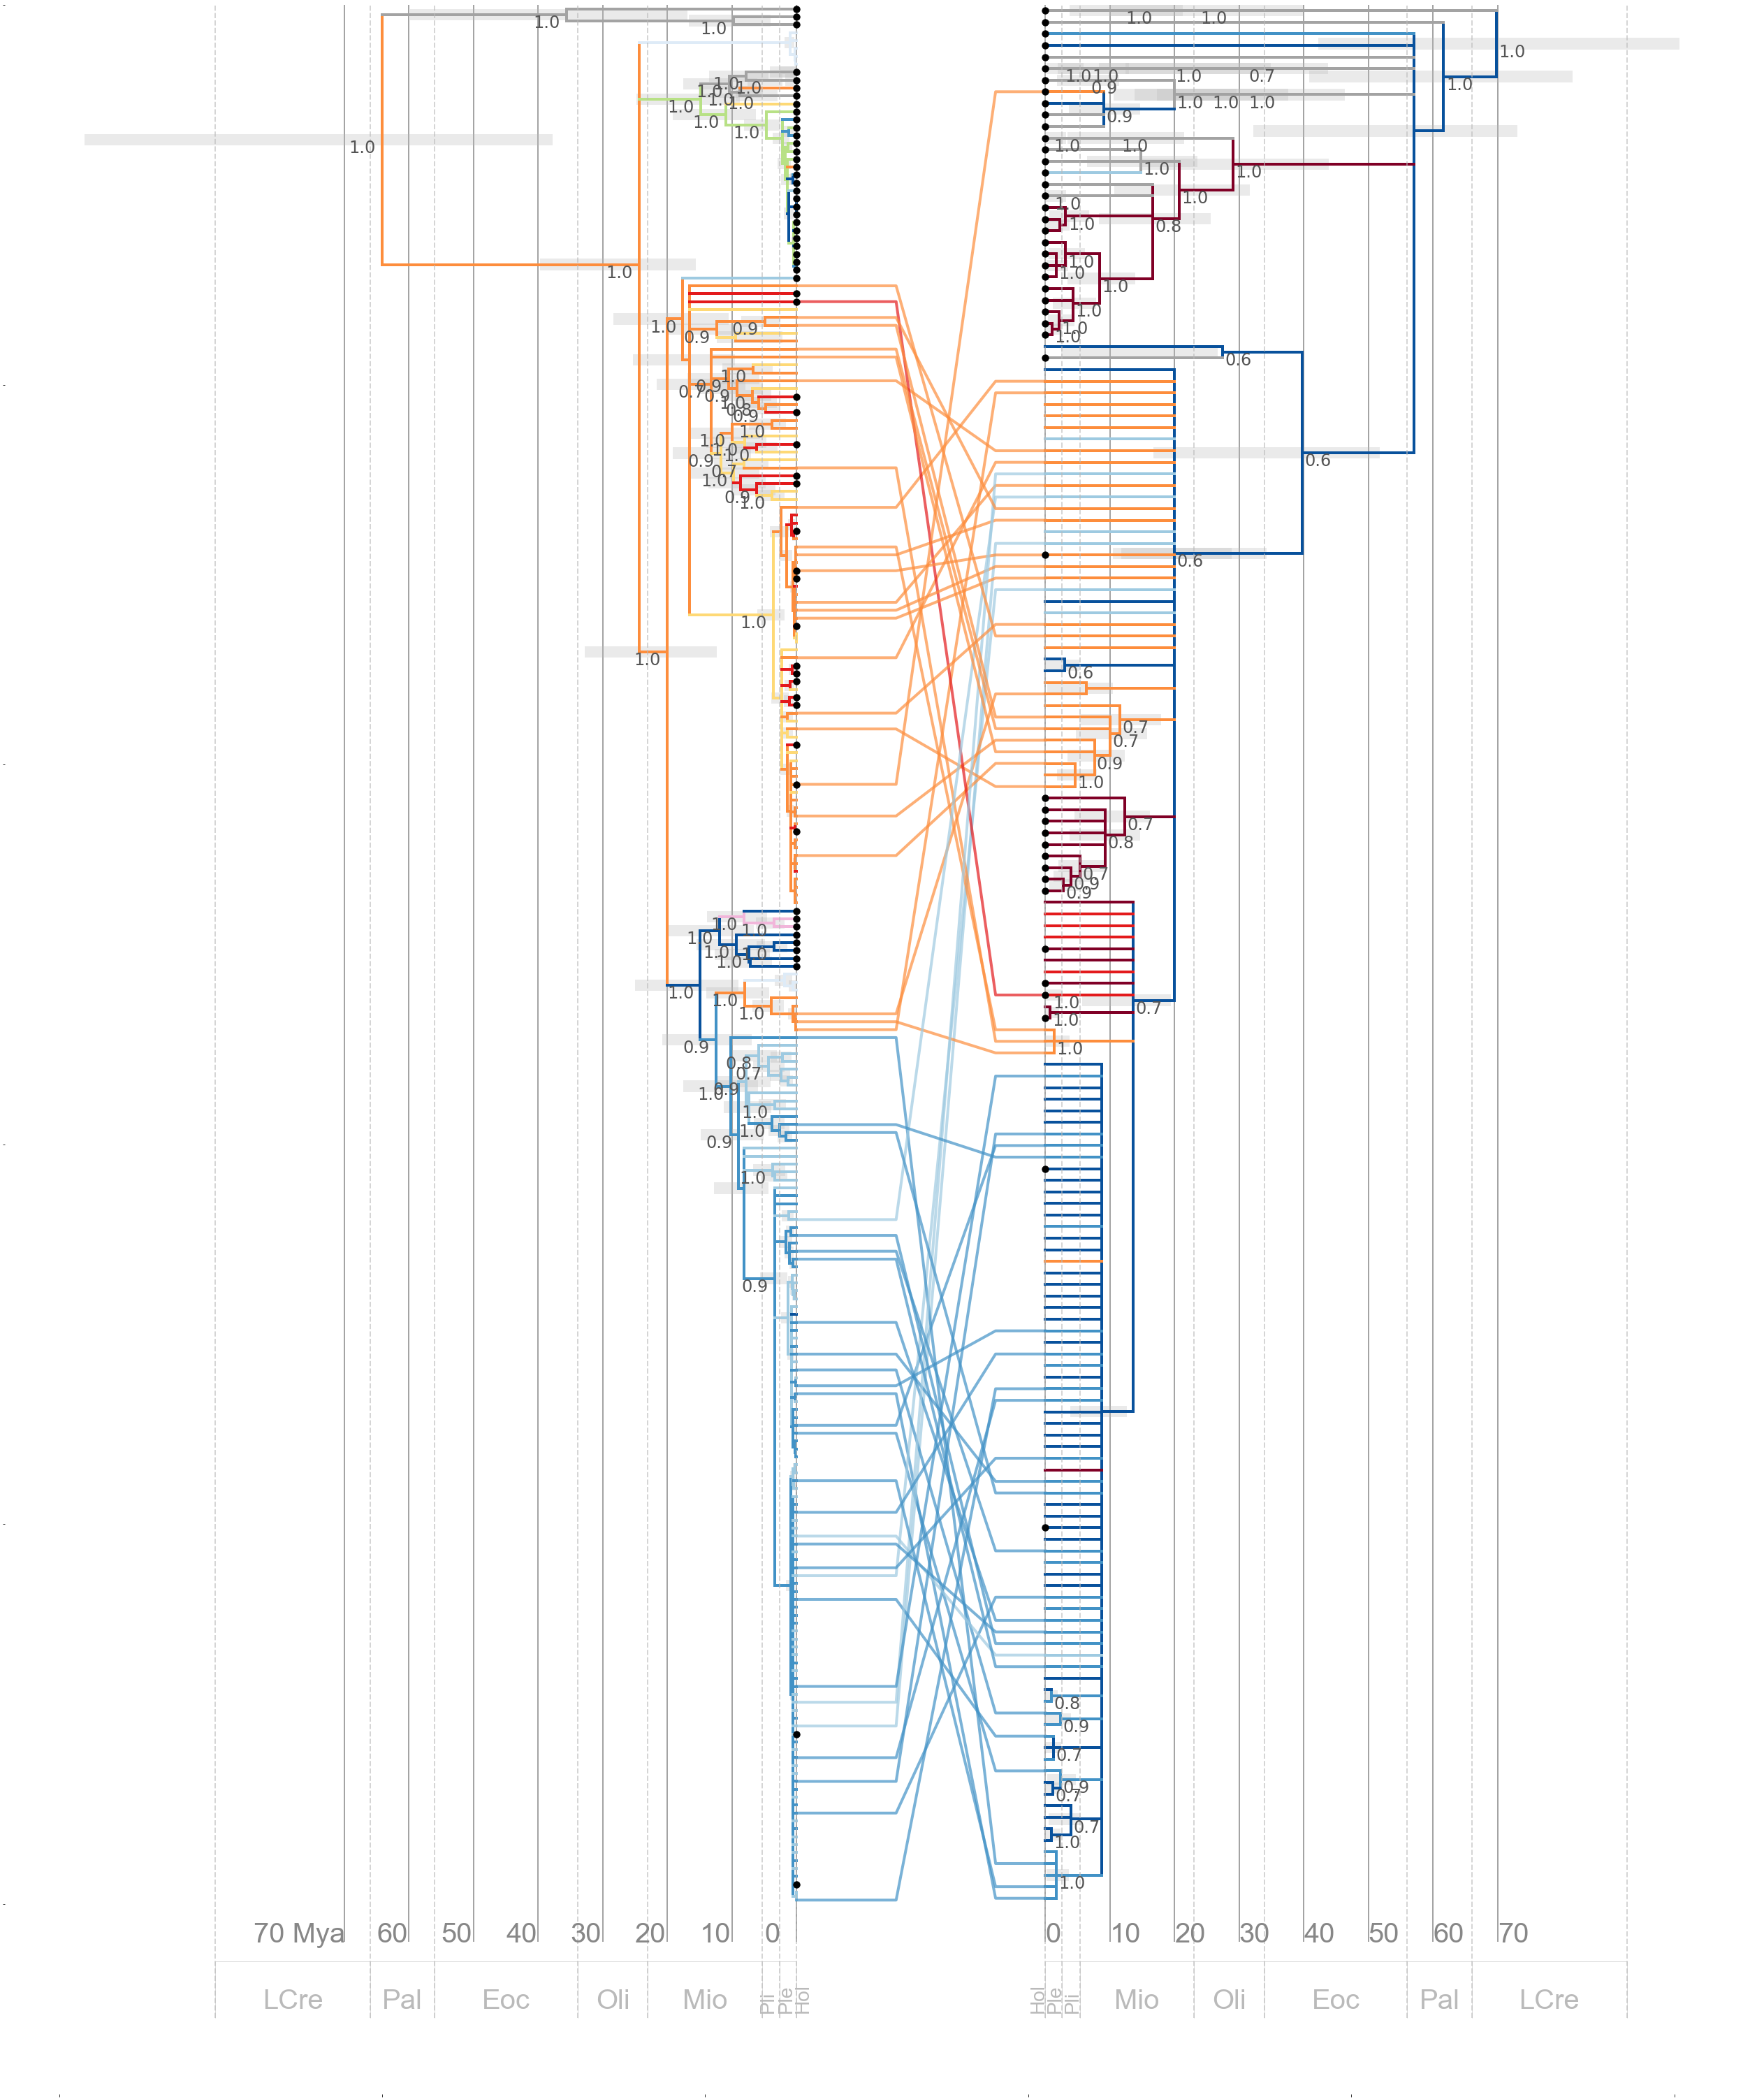

In [275]:
x_attr=lambda k: k.height+cumulative_displace
b_func=lambda k: 4
s_func=lambda k: 5
su_func=lambda k: 6
ct_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' #cmap(tip_positions[cc1][k.name][1]/float(cur_tree.ySpan))
cu_func=lambda k: 'k'
z_func=lambda k: 1000
zu_func=lambda k: 99

ant_x=''
plant_x=''

fig,ax = plt.subplots(figsize=(45,55),facecolor='w')
cumulative_displace=0 ## this tracks the "current" x position, so trees are plotted one after another

tree1=antreducedcoll
tree2=plantreducedcoll
cc1=tree1
tree1.plotTree(ax,x_attr=x_attr,y_attr=lambda k: k.y/tree1.ySpan,width=b_func,colour=ct_func) ## plot tree
skip=tree1.treeHeight*0.6 ## skip this many units between trees
x_attr=lambda k: tree1.treeHeight+skip+tree2.treeHeight-k.height ## for tree2 we'll offset x coordinates by the height of the tree and invert branches

tree2.plotTree(ax,x_attr=x_attr,y_attr=lambda k: k.y/tree2.ySpan,width=b_func,colour=ct_func) ## plot tree

for k in filter(lambda x: x.branchType=='leaf',tree1.Objects): ## grab leaf objects in tree1
    if k.name in [tip.name for tip in tree2.getExternal()]:
        
        pos_in_first_tree=tip_positions[cc1][k.name][1] ## fetch y coordinate of same tip in the first tree
        frac_pos=pos_in_first_tree/float(cur_tree.ySpan) ## normalize coordinate to be within interval [0.0,1.0]
        ant_x=k.height
        
        x=k.height ## get height
        y=k.y # k.y ## get y position
        matching_tip=tree2.getBranches(lambda x: x.branchType=='leaf' and x.name==k.name) ## fetch corresponding branch in tree2
        match_y=matching_tip.y
        xs=[x,tree1.treeHeight+0.4*skip,tree1.treeHeight+skip-0.2*skip,x_attr(matching_tip)] ## x coordinates for tangleline
        ys=[y/tree1.ySpan,y/tree1.ySpan,match_y/tree2.ySpan,match_y/tree2.ySpan] ## y coordinates for tangleline
        ax.plot(xs,ys,color=area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3',lw=4,alpha=0.7) # #8a8a8a  
        plant_x=x_attr(matching_tip)
    
    else:
        pass
    
for k in filter(lambda x: x.branchType=='leaf',tree2.Objects): ## grab leaf objects in tree1
    if k.name in [x.name for x in tree1.getExternal()]:
        pos_in_first_tree=tip_positions[cc1][k.name][1] ## fetch y coordinate of same tip in the first tree
        frac_pos=pos_in_first_tree/float(cur_tree.ySpan) ## normalize coordinate to be within interval [0.0,1.0]
        x=k.height ## get height
        y=k.y ## get y position

ax.set_ylim(-0.1,1)

print(ant_x,plant_x)

##### posterior and bars
for k in tree1.Objects:
    if k.branchType!='leaf':
        if 'posterior' in k.traits and k.traits['posterior'] > 0.60 and k.x < ant_x-3:
            ax.text(k.x-1,k.y/tree1.ySpan,'%1.1f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),va='top',ha='right',size=24,color='#545454',zorder=100)
        if  'height_95%_HPD' in k.traits: # and k.traits['height_95%_HPD'][1] < ant_x-5:
            height=0.006
            left=ant_x-k.traits['height_95%_HPD'][1]  # past to present
            bottom=(k.y/tree1.ySpan)-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.3)
            ax.add_patch(box)
    else:
        if antplant_dict[k.name] != 'Tococa guianensis':
            ax.scatter(ant_x,k.y/tree1.ySpan,s=350,marker='.',color='k',zorder=100)

for k in tree2.Objects:
    if k.branchType!='leaf':
        if 'posterior' in k.traits and k.traits['posterior'] > 0.60:
            ax.text(plant_x+(tree2.treeHeight-k.x)+4.5,k.y/tree2.ySpan,'%1.1f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),va='top',ha='right',size=24,color='#545454',zorder=100)
        if  'height_95%_HPD' in k.traits: # and k.traits['height_95%_HPD'][1] < ant_x-5:
            height=0.006
            left=plant_x+k.traits['height_95%_HPD'][0]  # past to present
            bottom=(k.y/tree2.ySpan)-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.3)
            ax.add_patch(box)
    else:
        if 'Tococa guianensis' not in planttipdisplay_dict[k.name]:
            ax.scatter(plant_x,k.y/tree2.ySpan,s=350,marker='.',color='k',zorder=100)
#             ax.text(plant_x,k.y/tree2.ySpan,s='%s'%(planttipdisplay_dict[k.name]),fontsize=12,color='k',zorder=100)

##### time lines
but=['Hol','Ple','Pli']
ax.hlines(y=-0.03,xmin=ant_x-geol_time_dict['LCre'][1],xmax=ant_x,ls='-',lw=1,color='#bababa',alpha=0.5)
for epoc,value in geol_time_dict.items():
    ax.vlines(x=ant_x-value[1],ymin=-0.06,ymax=-0.03,ls='-',lw=1,color='#bababa',alpha=0.5) # short vertical lines
    ax.vlines(x=ant_x-value[1],ymin=-0.06,ymax=ax.get_ylim()[1],ls='--',lw=2,color='#bababa',alpha=0.6)
    xbut,rotbut=(value[1]-1,90) if epoc in but else ((value[1]+value[0])/2,0)
    ax.text(x=ant_x-xbut,y=-(0.06+0.05)/2,s='%s'%(epoc),fontname='Arial',fontsize=28 if epoc in but else 40,color='#bababa',ha='center',rotation=rotbut)
    
but=['Hol','Ple','Pli']
ax.hlines(y=-0.03,xmin=plant_x+geol_time_dict['LCre'][1],xmax=plant_x,ls='-',lw=1,color='#bababa',alpha=0.5)
for epoc,value in list(geol_time_dict.items())[::-1]:
    ax.vlines(x=plant_x+value[1],ymin=-0.06,ymax=-0.03,ls='-',lw=1,color='#bababa',alpha=0.5) # short vertical lines
    ax.vlines(x=plant_x+value[1],ymin=-0.06,ymax=ax.get_ylim()[1],ls='--',lw=2,color='#bababa',alpha=0.6)
    xbut,rotbut=(value[1]-1,90) if epoc in but else ((value[1]+value[0])/2,0)
    ax.text(x=plant_x+xbut,y=-(0.06+0.05)/2,s='%s'%(epoc),fontname='Arial',fontsize=28 if epoc in but else 40,color='#bababa',ha='center',rotation=rotbut)

for x in range(0,80,10):
    ax.vlines(x=ant_x-x,ymin=-0.02,ymax=ax.get_ylim()[1],ls='-',lw=1.5,color='#878787',alpha=1,zorder=1)
    ax.text(x=ant_x-x-5 if x != 70 else ant_x-x-14,y=-0.02,s='%s'%(x) if x != 70 else '%s Mya'%(x),fontname='Arial',fontsize=40,color='#878787')
    
    ax.vlines(x=plant_x+x,ymin=-0.02,ymax=ax.get_ylim()[1],ls='-',lw=1.5,color='#878787',alpha=1,zorder=1)
    ax.text(x=plant_x+x,y=-0.02,s='%s'%(x),fontname='Arial',fontsize=40,color='#878787')
ax.set_xticklabels([])
ax.set_yticklabels([]) 
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

plt.savefig('./Fig2_Azteca_Tococa_mcct_20210106.pdf',pdi=300)

plt.show()

# Collapse clades with stem age younger than threshold

In [515]:
antmcct_path='Azteca_NCBI_MFT_OUT_ITS_30-01-18_mcct.tree'
plantreduced=planttree.reduceTree(keep_plants)

anttree=bt.loadNexus(antmcct_path,absoluteTime=False)
anttree.traverse_tree()
anttree.treeStats()
anttree.drawTree()
anttree.setAbsoluteTime(0)

cladethreshold=[-7,-7] # 8Mya for Azteca and 9 for Tococa
for i,tree in enumerate([anttree,plantreduced]):
    for k in tree.Objects:
        if isinstance(k,bt.leaf): # iterates through the tip
            cur_node=k
            while cur_node:
                cur_node.traits['locality']=tiplocal_dict[k.name] if k.name in tiplocal_dict.keys() else 'none' # annotates the parental nodes with the genus name. Done for colouring the branches based on genera
                cur_node=cur_node.parent

    for index,k in enumerate(tree.getInternal()):
        # identify the nodes to collapse by age
        if k.parent.absoluteTime and k.parent.absoluteTime < cladethreshold[i] <= k.absoluteTime:
            tree.collapseSubtree(k,'Clade %s'%(index),widthFunction=lambda x:0.5+np.log(len(x.leaves)))


Tree height: 64.152808
Tree length: 1246.039982
strictly bifurcating tree
annotations present

Numbers of objects in tree: 811 (405 nodes and 406 leaves)



In [516]:
cladetips_dict={}
for tree in [anttree,plantreduced]:
    for k in tree.Objects:
        if isinstance(k,bt.clade): # iterates through the tip
            k.traits['locality']=[x.traits['locality'] for x in k.subtree][1]            
            # stores a list of localities. len(list) will give the number of lineages
            cladetips_dict[k]=[x.traits['locality'] for x in k.subtree]
# [len(value) for key,value in cladetips_dict.items()]

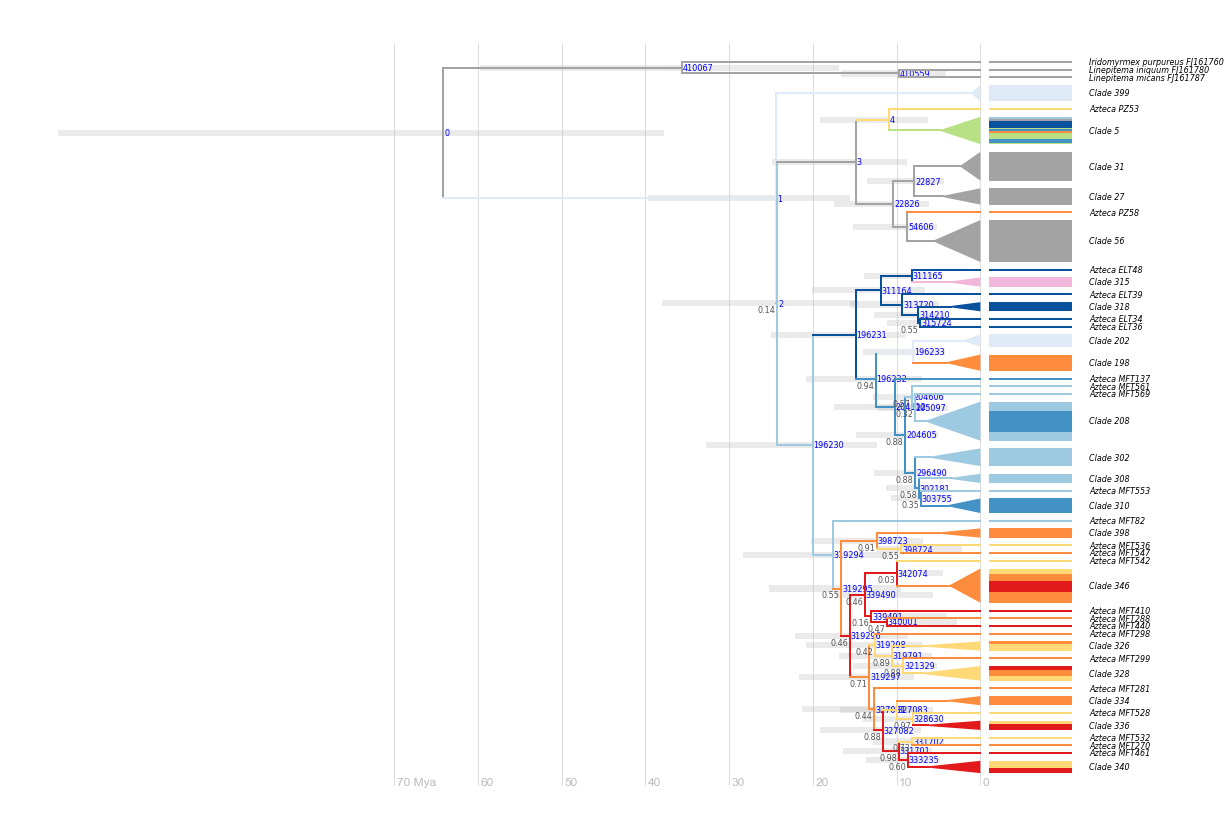

In [608]:
fig,ax = plt.subplots(figsize=(20,15),facecolor='none')

atree=anttree
x_attr=lambda k: k.x-atree.treeHeight if k.x else -atree.treeHeight
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
b_func=lambda k: 2 ## branch width function
s_func=lambda k: 600-30*k.height/anttree.treeHeight ## size of tips
z_func=lambda k: 100

atree.plotTree(ax,x_attr=x_attr,colour_function=bc_func,branchWidth=b_func) ## plot branches

for k in atree.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        ax.text(13,k.y,'%s'%(anttipdisplay_dict[k.name] if k.name in anttipdisplay_dict.keys() else k.name),
                va='center', ha='left',size=8,
                color='k', style='italic')
        if 'Clade' not in str(k.name):
            ax.hlines(y=k.y,xmin=1,xmax=11,lw=2,ls='-',color=area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3')
    else:
        if 'posterior' in k.traits and k.traits['posterior'] < 0.99:
            ax.text(k.height-atree.treeHeight-0.2,k.y-0.25,'%1.2f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),va='top',ha='right',size=8,color='#545454',zorder=1000)
        if  'height_95%_HPD' in k.traits and -k.traits['height_95%_HPD'][1] < cladethreshold[0]:
            height=0.8
            left=-k.traits['height_95%_HPD'][1]  # past to present
            bottom=k.y-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.3)
            ax.add_patch(box)
        ax.text(k.x-atree.treeHeight+0.1,k.y,'%s'%(k.index),va='center', ha='left',size=8,color='b') # node index, to be able to flip the clades for the map

    if isinstance(k,bt.clade): ## if not - it's actually a clade object
        x=k.height-atree.treeHeight
        y=k.y
        clade=plt.Polygon(([x,y-0.001*len(atree.Objects)],[x,y+0.001*len(atree.Objects)],[0,y+k.width/2.0],[0,y-k.width/2.0]),
                          facecolor=area_dict_col[area_dict[k.traits['locality']]],edgecolor='none',zorder=12) ## define a triangle polygon
        
        total=len(cladetips_dict[k]) # total bar height
        bottom=y-k.width/2.0
        for key,value in Counter(cladetips_dict[k]).items():
            height=(value*k.width)/total # width of the clade triangle base
#             ax.barh(y=y,width=width,height=k.width,left=left,align='center',edgecolor='none',facecolor=area_dict_col[area_dict[key]])
            ax.bar(x=1,bottom=bottom,height=height,width=10,align='edge',edgecolor='none',facecolor=area_dict_col[area_dict[key]])
            bottom+=height
            
        ax.add_patch(clade)
        
for x in range(0,80,10):
    ax.vlines(x=-x,ymin=-1,ymax=95,ls='-',lw=1,color='#bababa',alpha=0.5)
    ax.text(x=-x+0.3,y=-1,s='%s'%(x) if x != 70 else '%s Mya'%(x),fontname='Arial',fontsize=12,color='#bababa')
plt.xticks([])
plt.yticks([])
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
# plt.savefig('./Azteca_mcct_20210106.pdf',pdi=300)
plt.show()

# Rotate nodes in Azteca and plot the tree again

Rotating node 196230

In [609]:
for k in anttree.Objects:
    if k.index == 196230:
        k.children=k.children[::-1]
anttree.drawTree()

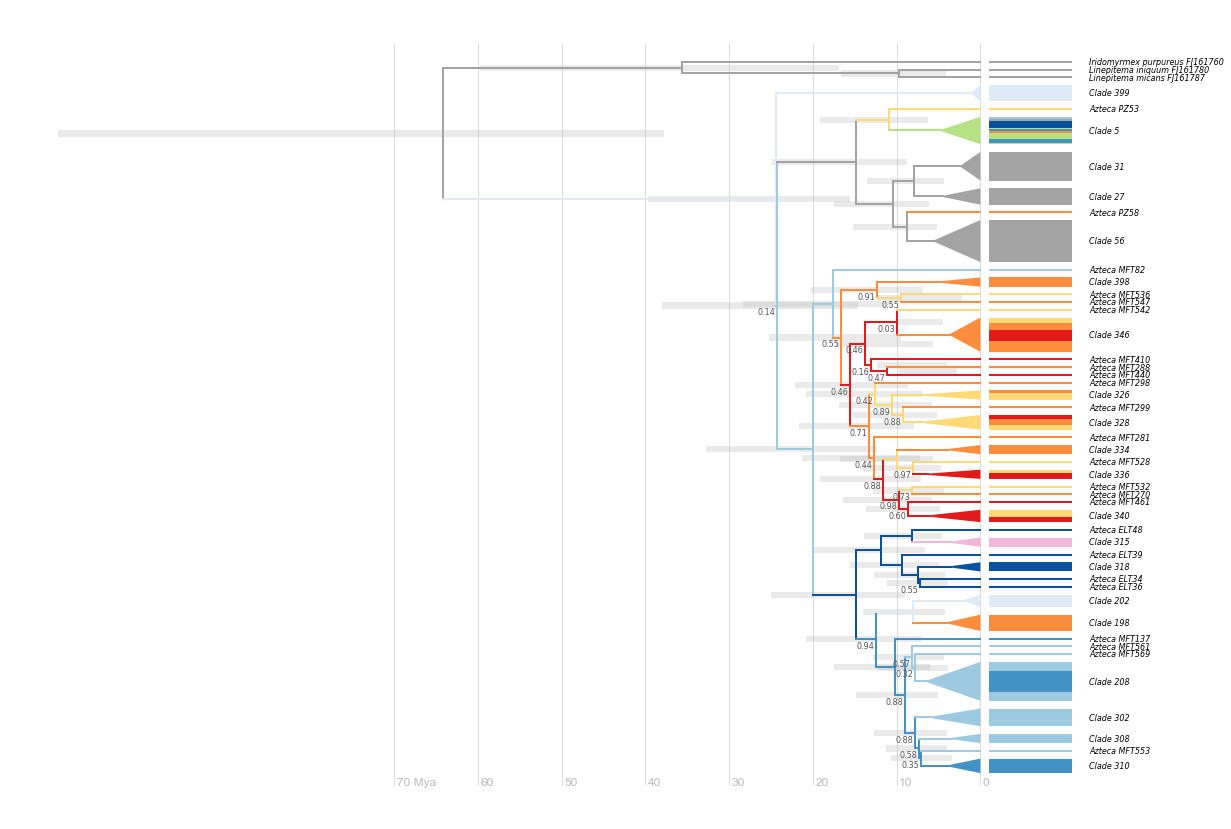

In [610]:
fig,ax = plt.subplots(figsize=(20,15),facecolor='none')

atree=anttree
x_attr=lambda k: k.x-atree.treeHeight if k.x else -atree.treeHeight
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
b_func=lambda k: 2 ## branch width function
s_func=lambda k: 600-30*k.height/anttree.treeHeight ## size of tips
z_func=lambda k: 100

atree.plotTree(ax,x_attr=x_attr,colour_function=bc_func,branchWidth=b_func) ## plot branches

for k in atree.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        ax.text(13,k.y,'%s'%(anttipdisplay_dict[k.name] if k.name in anttipdisplay_dict.keys() else k.name),
                va='center', ha='left',size=8,
                color='k', style='italic')
        if 'Clade' not in str(k.name):
            ax.hlines(y=k.y,xmin=1,xmax=11,lw=2,ls='-',color=area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3')
    else:
        if 'posterior' in k.traits and k.traits['posterior'] < 0.99:
            ax.text(k.height-atree.treeHeight-0.2,k.y-0.25,'%1.2f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),va='top',ha='right',size=8,color='#545454',zorder=1000)
        if  'height_95%_HPD' in k.traits and -k.traits['height_95%_HPD'][1] < cladethreshold[0]:
            height=0.8
            left=-k.traits['height_95%_HPD'][1]  # past to present
            bottom=k.y-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.3)
            ax.add_patch(box)

    if isinstance(k,bt.clade): ## if not - it's actually a clade object
        x=k.height-atree.treeHeight
        y=k.y
        clade=plt.Polygon(([x,y-0.001*len(atree.Objects)],[x,y+0.001*len(atree.Objects)],[0,y+k.width/2.0],[0,y-k.width/2.0]),
                          facecolor=area_dict_col[area_dict[k.traits['locality']]],edgecolor='none',zorder=12) ## define a triangle polygon
        
        total=len(cladetips_dict[k]) # total bar height
        bottom=y-k.width/2.0
        for key,value in Counter(cladetips_dict[k]).items():
            height=(value*k.width)/total # width of the clade triangle base
#             ax.barh(y=y,width=width,height=k.width,left=left,align='center',edgecolor='none',facecolor=area_dict_col[area_dict[key]])
            ax.bar(x=1,bottom=bottom,height=height,width=10,align='edge',edgecolor='none',facecolor=area_dict_col[area_dict[key]])
            bottom+=height
            
        ax.add_patch(clade)
for x in range(0,80,10):
    ax.vlines(x=-x,ymin=-1,ymax=95,ls='-',lw=1,color='#bababa',alpha=0.5)
    ax.text(x=-x+0.3,y=-1,s='%s'%(x) if x != 70 else '%s Mya'%(x),fontname='Arial',fontsize=12,color='#bababa')
plt.xticks([])
plt.yticks([])
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
# plt.savefig('./Azteca_mcct_20210106.pdf',pdi=300)
plt.show()

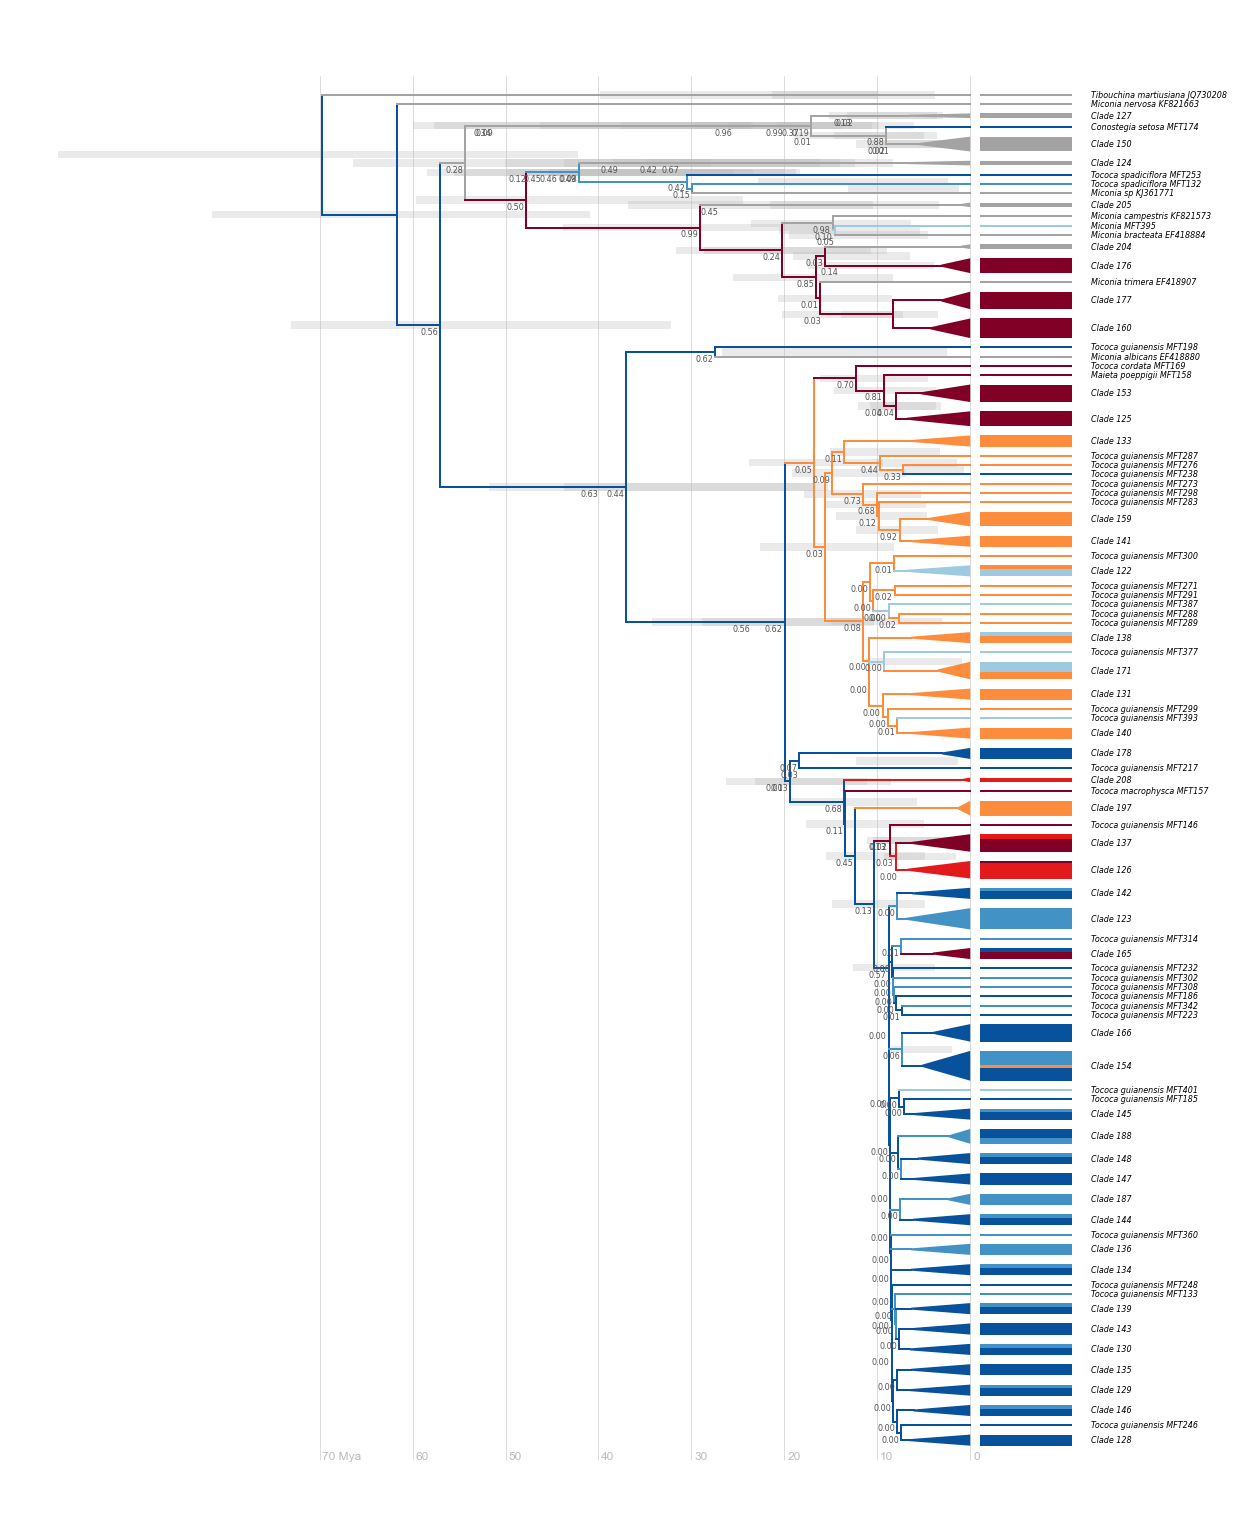

In [545]:
fig,ax = plt.subplots(figsize=(20,28),facecolor='none')

atree=plantreduced
x_attr=lambda k: k.x-atree.treeHeight if k.x else -atree.treeHeight
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
b_func=lambda k: 2 ## branch width function
s_func=lambda k: 600-30*k.height/atree.treeHeight ## size of tips
z_func=lambda k: 100

atree.plotTree(ax,x_attr=x_attr,colour_function=bc_func,branchWidth=b_func) ## plot branches

for k in atree.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        ax.text(13,k.y,'%s'%(planttipdisplay_dict[k.name] if k.name in planttipdisplay_dict.keys() else k.name),
                va='center', ha='left',size=8,
                color='k', style='italic')
        if 'Clade' not in str(k.name):
            ax.hlines(y=k.y,xmin=1,xmax=11,lw=2,ls='-',color=area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3')
    else:
        if 'posterior' in k.traits and k.traits['posterior'] < 0.99:
            ax.text(k.height-atree.treeHeight-0.2,k.y-0.25,'%1.2f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),va='top',ha='right',size=8,color='#545454',zorder=1000)
        if  'height_95%_HPD' in k.traits and -k.traits['height_95%_HPD'][1] < cladethreshold[1]:
            height=0.8
            left=-k.traits['height_95%_HPD'][1]  # past to present
            bottom=k.y-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.3)
            ax.add_patch(box)

    if isinstance(k,bt.clade): ## if not - it's actually a clade object
        x=k.height-atree.treeHeight
        y=k.y
        clade=plt.Polygon(([x,y-0.0005*len(atree.Objects)],[x,y+0.0005*len(atree.Objects)],[0,y+k.width/2.0],[0,y-k.width/2.0]),
                          facecolor=area_dict_col[area_dict[k.traits['locality']]],edgecolor='none',zorder=12) ## define a triangle polygon
        
        total=len(cladetips_dict[k]) # total bar height
        bottom=y-k.width/2.0
        for key,value in Counter(cladetips_dict[k]).items():
            height=(value*k.width)/total # width of the clade triangle base
#             ax.barh(y=y,width=width,height=k.width,left=left,align='center',edgecolor='none',facecolor=area_dict_col[area_dict[key]])
            ax.bar(x=1,bottom=bottom,height=height,width=10,align='edge',edgecolor='none',facecolor=area_dict_col[area_dict[key]])
            bottom+=height
            
        ax.add_patch(clade)
for x in range(0,80,10):
    ax.vlines(x=-x,ymin=-1,ymax=148,ls='-',lw=1,color='#bababa',alpha=0.5)
    ax.text(x=-x+0.3,y=-1,s='%s'%(x) if x != 70 else '%s Mya'%(x),fontname='Arial',fontsize=12,color='#bababa')
plt.xticks([])
plt.yticks([])
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
# plt.savefig('./Azteca_mcct_20210106.pdf',pdi=300)
plt.show()

# Tanglegram

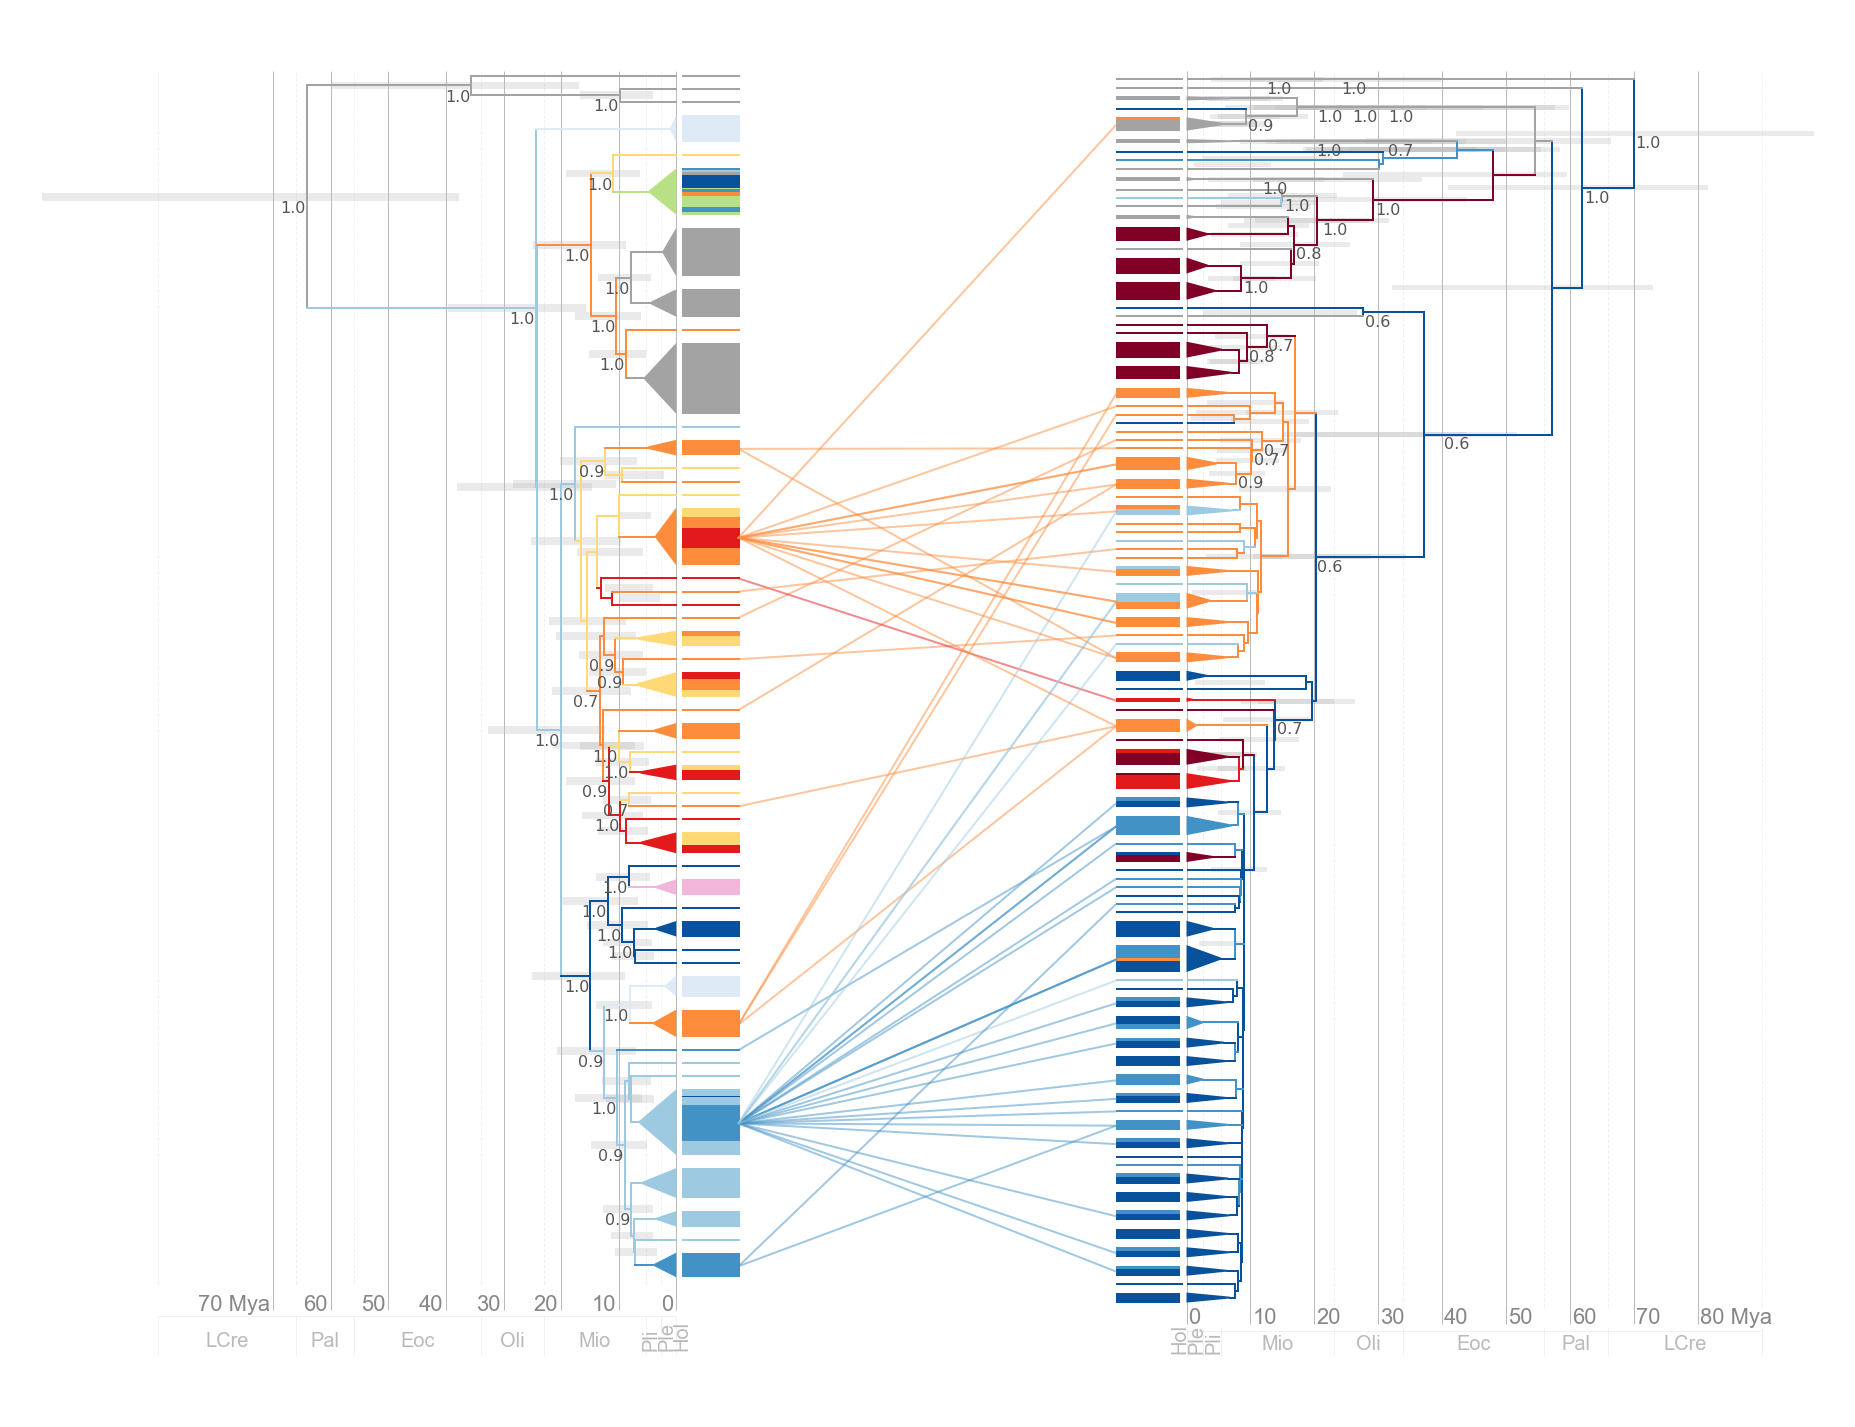

In [636]:
fig = plt.figure(figsize=(33,26),facecolor='w') 
G = gridspec.GridSpec(1,2,wspace=0.4,hspace=0.0)

ax1=plt.subplot(G[0,0],facecolor='none')
atree=anttree
x_attr=lambda k: k.x-atree.treeHeight if k.x else -atree.treeHeight
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
b_func=lambda k: 2 ## branch width function
s_func=lambda k: 600-30*k.height/anttree.treeHeight ## size of tips
z_func=lambda k: 100
atree.plotTree(ax1,x_attr=x_attr,colour_function=bc_func,branchWidth=b_func) ## plot branches
ant_ytips=tangled(anttree)
for k in atree.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
#         ax1.text(13,k.y,'%s'%(anttipdisplay_dict[k.name] if k.name in anttipdisplay_dict.keys() else k.name),
#                 va='center', ha='left',size=8,
#                 color='k', style='italic')
        if 'Clade' not in str(k.name):
            ax1.hlines(y=k.y,xmin=1,xmax=11,lw=2,ls='-',color=area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3')
    else:
        if 'posterior' in k.traits and k.traits['posterior'] > 0.60:
            ax1.text(k.height-atree.treeHeight-0.2,k.y-0.25,'%1.1f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),va='top',ha='right',size=16,color='#545454',zorder=1000)
        if  'height_95%_HPD' in k.traits and -k.traits['height_95%_HPD'][1] < cladethreshold[0]:
            height=0.6
            left=-k.traits['height_95%_HPD'][1]  # past to present
            bottom=k.y-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.3)
            ax1.add_patch(box)
    if isinstance(k,bt.clade): ## if not - it's actually a clade object
        x=k.height-atree.treeHeight
        y=k.y
        clade=plt.Polygon(([x,y-0.001*len(atree.Objects)],[x,y+0.001*len(atree.Objects)],[0,y+k.width/2.0],[0,y-k.width/2.0]),
                          facecolor=area_dict_col[area_dict[k.traits['locality']]],edgecolor='none',zorder=12) ## define a triangle polygon
        total=len(cladetips_dict[k]) # total bar height
        bottom=y-k.width/2.0
        for key,value in Counter(cladetips_dict[k]).items():
            height=(value*k.width)/total # width of the clade triangle base
#             ax.barh(y=y,width=width,height=k.width,left=left,align='center',edgecolor='none',facecolor=area_dict_col[area_dict[key]])
            ax1.bar(x=1,bottom=bottom,height=height,width=10,align='edge',edgecolor='none',facecolor=area_dict_col[area_dict[key]])
            bottom+=height
        ax1.add_patch(clade)
ymax=93
for x in range(0,80,10):
    ax1.vlines(x=-x,ymin=-2,ymax=ymax,ls='-',lw=1,color='#bababa',alpha=1)
    ax1.text(x=-x-0.5,y=-2,s='%s'%(x) if x != 70 else '%s Mya'%(x),fontname='Arial',fontsize=22,color='#878787',ha='right')
plt.xticks([])
plt.yticks([])
[ax1.spines[loc].set_visible(False) for loc in ax1.spines]

but=['Hol','Ple','Pli']
ax1.hlines(y=-2.5,xmin=0,xmax=-geol_time_dict['LCre'][1],ls='-',lw=1,color='#bababa',alpha=0.2)
for epoc,value in geol_time_dict.items():
    ax1.vlines(x=-value[1],ymin=-5.5,ymax=-2.5,ls='-',lw=1,color='#bababa',alpha=0.2)
    ax1.vlines(x=-value[1],ymin=0,ymax=ymax,ls='--',lw=1,color='#bababa',alpha=0.2)
    xbut,rotbut=(value[1]-1,90) if epoc in but else ((value[1]+value[0])/2,0)
    ax1.text(x=-xbut,y=-4.8,s='%s'%(epoc),fontname='Arial',fontsize=20,color='#bababa',ha='center',rotation=rotbut)

###---------------------------------------------------------------------------------------------------------------------------------------------------------------------
ax2=plt.subplot(G[0,1],facecolor='none')

patree=plantreduced
x_attr=lambda k: -k.height# k.x-patree.treeHeight if k.x else -patree.treeHeight
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
b_func=lambda k: 2 ## branch width function
s_func=lambda k: 600-30*k.height/patree.treeHeight ## size of tips
z_func=lambda k: 100
patree.plotTree(ax2,x_attr=x_attr,colour_function=bc_func,branchWidth=b_func) ## plot branches
plant_ytips=tangled(plantreduced,cladefix=0.0005)
for k in patree.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
#         ax.text(13,k.y,'%s'%(planttipdisplay_dict[k.name] if k.name in planttipdisplay_dict.keys() else k.name),
#                 va='center', ha='left',size=8,
#                 color='k', style='italic')
        if 'Clade' not in str(k.name):
            ax2.hlines(y=k.y,xmin=-81,xmax=-70.5,lw=2,ls='-',color=area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3')
    else:
        if 'posterior' in k.traits and k.traits['posterior'] > 0.60:
            ax2.text(-k.height+0.3,k.y-0.25,'%1.1f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),va='top',ha='left',size=16,color='#545454',zorder=1000)
        if  'height_95%_HPD' in k.traits and -k.traits['height_95%_HPD'][1] < cladethreshold[1]:
            height=0.6
            left=k.traits['height_95%_HPD'][0]  # past to present
            bottom=k.y-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((-70+left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.3)
#             ax2.text(x=-70+left,y=bottom,s='%1.1f'%(k.traits['height_95%_HPD'][0]))
            ax2.add_patch(box)
    if isinstance(k,bt.clade): ## if not - it's actually a clade object
        x=-k.height#-patree.treeHeight
        y=k.y
        clade=plt.Polygon(([x,y-0.0005*len(patree.Objects)],[x,y+0.0005*len(patree.Objects)],[-70,y+k.width/2.0],[-70,y-k.width/2.0]),
                          facecolor=area_dict_col[area_dict[k.traits['locality']]],edgecolor='none',zorder=12) ## define a triangle polygon
        total=len(cladetips_dict[k]) # total bar height
        bottom=y-k.width/2.0
        for key,value in Counter(cladetips_dict[k]).items():
            height=(value*k.width)/total # width of the clade triangle base
#             ax.barh(y=y,width=width,height=k.width,left=left,align='center',edgecolor='none',facecolor=area_dict_col[area_dict[key]])
            ax2.bar(x=-82+1,bottom=bottom,height=height,width=10,align='edge',edgecolor='none',facecolor=area_dict_col[area_dict[key]])
            bottom+=height
        ax2.add_patch(clade)
ymax=147
for x in range(0,90,10):
    ax2.vlines(x=-x+10,ymin=-2,ymax=ymax,ls='-',lw=1,color='#bababa',alpha=1)
    ax2.text(x=-x+10.3,y=-2,s='%s'%(80-x) if x != 0 else '%s Mya'%(80-x),fontname='Arial',fontsize=22,color='#878787',ha='left')
plt.xticks([])
plt.yticks([])
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

but=['Hol','Ple','Pli']
ax2.hlines(y=-2.9,xmin=-70,xmax=-70+geol_time_dict['LCre'][1],ls='-',lw=1,color='#bababa',alpha=0.2)
for epoc,value in geol_time_dict.items():
    ax2.vlines(x=-70+value[1],ymin=-5.8,ymax=-2.5,ls='-',lw=1,color='#bababa',alpha=0.2)
    ax2.vlines(x=-70+value[1],ymin=0,ymax=ymax,ls='--',lw=1,color='#bababa',alpha=0.2)
    xbut,rotbut=(value[1]-1,90) if epoc in but else ((value[1]+value[0])/2,0)
    ax2.text(x=-70+xbut,y=-5,s='%s'%(epoc),fontname='Arial',fontsize=20,color='#bababa',ha='center',rotation=rotbut)
    
for key,value in ant_ytips.items():
    if key in plant_ytips.keys():       
        xyA=(k.x-atree.treeHeight+6,ant_ytips[key]) # in axes coordinates
        xyB=(-81,plant_ytips[key]) # x in axes coordinates, y in data coordinates
        coordsA = 'data'
        coordsB = 'data'
        con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,axesA=ax1,axesB=ax2,arrowstyle="-",clip_on=False,zorder=2,alpha=0.5,lw=2,
                              color=area_dict_col[area_dict[tiplocal_dict[key]]] if key in tiplocal_dict.keys() else '#a3a3a3')
#         ax1.text(x=k.x-atree.treeHeight+6,y=ant_ytips[key],s='%1.1f'%(ant_ytips[key]))
        ax2.add_artist(con)
plt.savefig('./Fig2_Azteca_Tococa_mcct_20210106.pdf',pdi=300)
plt.show()